<a href="https://colab.research.google.com/github/Virushaba/DDoS-Attack-Detection-and-Mitigation/blob/main/NB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# --- Cell 1: Install & Import ---
!pip install qutip cryptography tensorflow scikit-learn pandas matplotlib seaborn
import numpy as np
import pandas as pd
import tensorflow as tf
from qutip import basis
import matplotlib.pyplot as plt
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding
from cryptography.hazmat.backends import default_backend
import os

In [33]:
# --- Cell 2: Load PRE-TRAINED Model & TEST Data ---
from google.colab import files

# Load your pre-trained model (already trained in Notebook 0)
#model = tf.keras.models.load_model('best_model.keras')  # No training needed!
#print("✅ Pre-trained model loaded")

# Load TEST data (new, unseen samples)
test_data = pd.read_csv('test_data.csv')  # Your separate test set
X_test = test_data.drop('Unified_Label', axis=1).values
y_test = test_data['Unified_Label'].values
print(f"✅ Test data loaded: {X_test.shape}")

import tensorflow as tf

# Re-define your focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        probs = tf.reduce_sum(y_true * y_pred, axis=1)
        focal = alpha * tf.pow((1. - probs), gamma) * cross_entropy
        return focal
    return focal_loss_fixed

# Load model with custom loss
model = tf.keras.models.load_model(
    "best_model.keras",
    custom_objects={"focal_loss_fixed": focal_loss()}
)

print("✅ Pre-trained model loaded successfully!")


✅ Test data loaded: (29364, 41)
✅ Pre-trained model loaded successfully!


In [34]:
# --- Cell 4: QKD Simulation with Eavesdropping ---
def simulate_bb84_key(num_bits=256, eavesdrop_prob=0.0):
    zero, one = basis(2, 0), basis(2, 1)
    rect_bases = [zero, one]
    diag_bases = [(zero + one).unit(), (zero - one).unit()]

    alice_bits = np.random.randint(0, 2, num_bits)
    alice_bases = np.random.randint(0, 2, num_bits)
    bob_bases = np.random.randint(0, 2, num_bits)

    def encode(bit, basis_choice):
        return rect_bases[bit] if basis_choice == 0 else diag_bases[bit]

    def measure(qubit, basis_choice):
        proj0 = rect_bases[0] * rect_bases[0].dag() if basis_choice == 0 else diag_bases[0] * diag_bases[0].dag()
        proj1 = rect_bases[1] * rect_bases[1].dag() if basis_choice == 0 else diag_bases[1] * diag_bases[1].dag()
        p0 = (proj0 * qubit).norm()**2
        return 0 if np.random.rand() < p0 else 1

    # Simulate eavesdropping
    def eavesdrop(qubit):
        if np.random.rand() < eavesdrop_prob:
            eve_basis = np.random.randint(0, 2)
            result = measure(qubit, eve_basis)
            return encode(result, eve_basis)
        return qubit

    alice_qubits = [encode(b, basis_choice) for b, basis_choice in zip(alice_bits, alice_bases)]
    eavesdropped_qubits = [eavesdrop(q) for q in alice_qubits]
    bob_results = [measure(q, b) for q, b in zip(eavesdropped_qubits, bob_bases)]

    # Sift key
    sifted_alice = [bit for i, bit in enumerate(alice_bits) if alice_bases[i] == bob_bases[i]]
    sifted_bob = [res for i, res in enumerate(bob_results) if alice_bases[i] == bob_bases[i]]

    errors = sum(a != b for a, b in zip(sifted_alice, sifted_bob))
    qber = errors / len(sifted_alice) if sifted_alice else 1.0

    if qber > 0.11 or len(sifted_alice) < 16:
        return None, qber
    key_bits = sifted_alice[:256]
    key_bytes = np.packbits(key_bits).tobytes()
    # Verify key size
    if len(key_bytes) != 32:
        # If not 32 bytes, pad with zeros or truncate (for testing)
        key_bytes = key_bytes.ljust(32, b'\x00')[:32]

    return key_bytes, qber
    #return key_bytes, qber

# Test QKD
#key, qber_val = simulate_bb84_key(eavesdrop_prob=0.1)
#print(f"QKD Key Generated: {key is not None}, QBER: {qber_val:.2%}")

# Now run the experiment
results = []
eavesdrop_probs = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25]
for prob in eavesdrop_probs:
    for trial in range(50):
        key, qber = simulate_bb84_key(eavesdrop_prob=prob)
        results.append({'Eavesdrop_Prob': prob, 'QBER': qber, 'Success': key is not None})

qkd_df = pd.DataFrame(results)
qkd_df.to_csv('qkd_results.csv', index=False)
print("QKD experiment completed. Data saved to qkd_results.csv")

QKD experiment completed. Data saved to qkd_results.csv


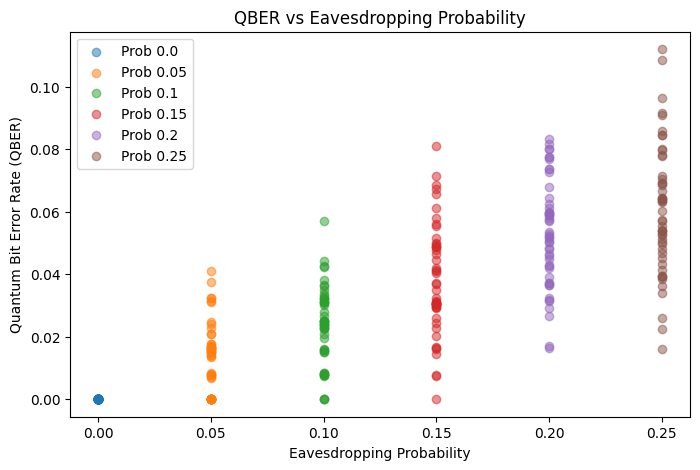

In [35]:
# --- Cell 3: Plot QBER vs Eavesdropping ---
plt.figure(figsize=(8, 5))
for prob in eavesdrop_probs:
    subset = qkd_df[qkd_df['Eavesdrop_Prob'] == prob]
    plt.scatter([prob] * len(subset), subset['QBER'], alpha=0.5, label=f'Prob {prob}')
plt.xlabel('Eavesdropping Probability')
plt.ylabel('Quantum Bit Error Rate (QBER)')
plt.title('QBER vs Eavesdropping Probability')
plt.legend()
plt.show()

In [36]:
# --- Cell 5: AES Encryption Functions ---
def aes_encrypt(key, plaintext):
    backend = default_backend()
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=backend)
    encryptor = cipher.encryptor()
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(plaintext.encode()) + padder.finalize()
    ct = encryptor.update(padded_data) + encryptor.finalize()
    return iv + ct

def aes_decrypt(key, ciphertext):
    iv, ct = ciphertext[:16], ciphertext[16:]
    backend = default_backend()
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=backend)
    decryptor = cipher.decryptor()
    padded_plaintext = decryptor.update(ct) + decryptor.finalize()
    unpadder = padding.PKCS7(128).unpadder()
    return unpadder.update(padded_plaintext) + unpadder.finalize()

# Test AES
test_key = os.urandom(32)
test_msg = "Test control message"
encrypted = aes_encrypt(test_key, test_msg)
decrypted = aes_decrypt(test_key, encrypted)
print(f"AES Test: {decrypted.decode()}")

AES Test: Test control message


In [38]:
def offline_integration_test():
    try:
        print("1. Starting QKD simulation...")

        # Add timeout protection
        import signal
        def timeout_handler(signum, frame):
            raise TimeoutError("QKD simulation timed out")
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(30)  # 30-second timeout

        # 1️⃣ Generate QKD Key
        key, qber = simulate_bb84_key(eavesdrop_prob=0.1)
        signal.alarm(0)  # disable alarm
        print(f"   QKD completed. Key: {key is not None}, QBER: {qber}")
        if key is None:
            return

        # 2️⃣ Get a random test sample
        idx = np.random.randint(0, len(X_test))
        flow_features, true_label = X_test[idx], y_test[idx]
        print(f"   Sample index: {idx}, True label: {true_label}")

        # 3️⃣ Scale features using the SAME scaler used in training
        flow_features_scaled = scaler.transform(flow_features.reshape(1, -1))

        # 4️⃣ Predict with the model
        prediction = model.predict(flow_features_scaled.reshape(1, 41, 1), verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]

        # 5️⃣ Detect attack: anything not class 0 is attack
        attack_detected = predicted_class != 0

        # 6️⃣ Debug: show all probabilities
        print(f"   Prediction probabilities: {prediction[0].round(4)}")
        print(f"   Predicted class: {predicted_class}, Attack detected: {attack_detected}")

        # 7️⃣ Encrypt/Decrypt message using QKD key
        msg = "drop_flow" if attack_detected else "allow_flow"
        encrypted_msg = aes_encrypt(key, msg)
        decrypted_msg = aes_decrypt(key, encrypted_msg)
        print(f"   Message: {msg}, Decrypted: {decrypted_msg.decode()}")

    except TimeoutError:
        print("❌ QKD simulation timed out after 30 seconds")
    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

# Run the test
print("🚀 Starting integration test with timeout protection...")
offline_integration_test()


🚀 Starting integration test with timeout protection...
1. Starting QKD simulation...
   QKD completed. Key: True, QBER: 0.058333333333333334
   Sample index: 15453, True label: 5
   Prediction probabilities: [0.     0.0255 0.     0.     0.     0.9745 0.     0.    ]
   Predicted class: 5, Attack detected: True
   Message: drop_flow, Decrypted: drop_flow


In [39]:
# Run multiple tests to see overall performance
print("\n🧪 Running multiple integration tests...")
for i in range(10):
    print(f"\nTest {i+1}:")
    offline_integration_test()


🧪 Running multiple integration tests...

Test 1:
1. Starting QKD simulation...
   QKD completed. Key: True, QBER: 0.05737704918032787
   Sample index: 27990, True label: 0
   Prediction probabilities: [9.827e-01 3.000e-04 0.000e+00 0.000e+00 0.000e+00 1.700e-02 0.000e+00
 0.000e+00]
   Predicted class: 0, Attack detected: False
   Message: allow_flow, Decrypted: allow_flow

Test 2:
1. Starting QKD simulation...
   QKD completed. Key: True, QBER: 0.01694915254237288
   Sample index: 5200, True label: 0
   Prediction probabilities: [0.8739 0.1169 0.     0.     0.     0.0092 0.     0.    ]
   Predicted class: 0, Attack detected: False
   Message: allow_flow, Decrypted: allow_flow

Test 3:
1. Starting QKD simulation...
   QKD completed. Key: True, QBER: 0.007936507936507936
   Sample index: 24725, True label: 1
   Prediction probabilities: [0.     0.9689 0.     0.     0.     0.0311 0.     0.    ]
   Predicted class: 1, Attack detected: True
   Message: drop_flow, Decrypted: drop_flow

Tes

In [40]:
import pandas as pd

def run_multiple_qkd_tests(n_tests=100):
    results = []

    for i in range(n_tests):
        try:
            # 1️⃣ Generate QKD key
            key, qber = simulate_bb84_key(eavesdrop_prob=0.1)
            if key is None:
                continue

            # 2️⃣ Select random test sample
            idx = np.random.randint(0, len(X_test))
            flow_features, true_label = X_test[idx], y_test[idx]

            # 3️⃣ Scale features
            flow_features_scaled = scaler.transform(flow_features.reshape(1, -1))

            # 4️⃣ Predict
            prediction = model.predict(flow_features_scaled.reshape(1, 41, 1), verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]
            attack_detected = predicted_class != 0

            # 5️⃣ Record results
            results.append({
                'Test': i+1,
                'Flow Index': idx,
                'True Label': true_label,
                'Predicted Class': predicted_class,
                'Attack Detected': attack_detected,
                'Prediction Probabilities': prediction[0].round(4),
                'QBER': qber
            })

        except Exception as e:
            print(f"❌ Test {i+1} error: {e}")

    # 6️⃣ Create DataFrame
    df_results = pd.DataFrame(results)

    # 7️⃣ Summary statistics
    total_tests = len(df_results)
    attack_true = df_results['True Label'] != 0
    attack_pred = df_results['Attack Detected']

    tp = ((attack_true) & (attack_pred)).sum()
    tn = ((~attack_true) & (~attack_pred)).sum()
    fp = ((~attack_true) & (attack_pred)).sum()
    fn = ((attack_true) & (~attack_pred)).sum()

    accuracy = (tp + tn) / total_tests
    attack_detection_accuracy = tp / attack_true.sum() if attack_true.sum() > 0 else 0

    print("📊 QKD Integration Summary:")
    print(f"Total Tests: {total_tests}")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Attack Detection Accuracy: {attack_detection_accuracy:.4f}")

    return df_results

# Run 100 tests
df_qkd = run_multiple_qkd_tests(n_tests=100)
df_qkd.head()


📊 QKD Integration Summary:
Total Tests: 100
TP: 46, TN: 52, FP: 1, FN: 1
Overall Accuracy: 0.9800
Attack Detection Accuracy: 0.9787


,Test,Flow Index,True Label,Predicted Class,Attack Detected,Prediction Probabilities,QBER
0,1,5739,5,5,True,"[0.0, 0.0148, 0.0, 0.0, 0.0, 0.9852, 0.0, 0.0]",0.061069
1,2,10657,0,0,False,"[0.9969, 0.0, 0.0, 0.0, 0.0, 0.0031, 0.0, 0.0]",0.023810
2,3,15668,0,0,False,"[0.8563, 0.0, 0.1432, 1e-04, 0.0, 0.0002, 0.00...",0.053435
3,4,15358,0,0,False,"[0.8849, 0.0933, 0.0, 0.0, 0.0, 0.0219, 0.0, 0.0]",0.023438
4,5,22161,0,6,True,"[0.3976, 0.0, 0.0132, 0.0, 0.0, 0.0, 0.5891, 0.0]",0.028369


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Test'].plot(kind='hist', bins=20, title='Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Flow Index'].plot(kind='hist', bins=20, title='Flow Index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['True Label'].plot(kind='hist', bins=20, title='True Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Attack Detected').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Test', y='Flow Index', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Flow Index', y='True Label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='True Label', y='Predicted Class', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Flow Index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Attack Detected')):
  _plot_series(series, series_name, i)
  fig.legend(title='Attack Detected', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Flow Index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['True Label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Attack Detected')):
  _plot_series(series, series_name, i)
  fig.legend(title='Attack Detected', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('True Label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Predicted Class']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Attack Detected')):
  _plot_series(series, series_name, i)
  fig.legend(title='Attack Detected', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Predicted Class')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['QBER']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Attack Detected')):
  _plot_series(series, series_name, i)
  fig.legend(title='Attack Detected', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('QBER')

from matplotlib import pyplot as plt
_df_13['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Test'].plot(kind='line', figsize=(8, 4), title='Test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Flow Index'].plot(kind='line', figsize=(8, 4), title='Flow Index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['True Label'].plot(kind='line', figsize=(8, 4), title='True Label')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Attack Detected'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='Attack Detected', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Attack Detected'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='Test', y='Attack Detected', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Attack Detected'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Flow Index', y='Attack Detected', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Attack Detected'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='True Label', y='Attack Detected', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# @title True Label

from matplotlib import pyplot as plt
df_qkd['True Label'].plot(kind='hist', bins=20, title='True Label')
plt.gca().spines[['top', 'right',]].set_visible(False)

/tmp/ipython-input-133603986.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_qkd, x='True Label', y='Attack Detected', inner='stick', palette='Dark2')


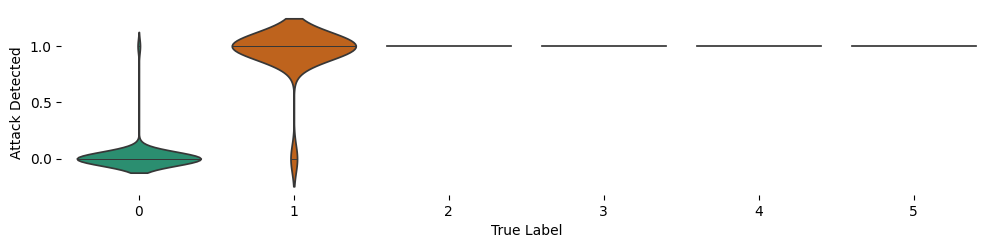

In [45]:
# @title Attack Detected vs True Label

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_qkd['Attack Detected'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_qkd, x='True Label', y='Attack Detected', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-1466582346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_20, x='True Label', y='Attack Detected', inner='stick', palette='Dark2')


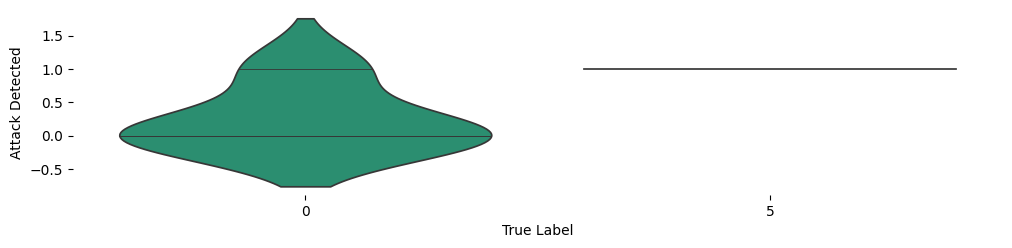

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Attack Detected'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='True Label', y='Attack Detected', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

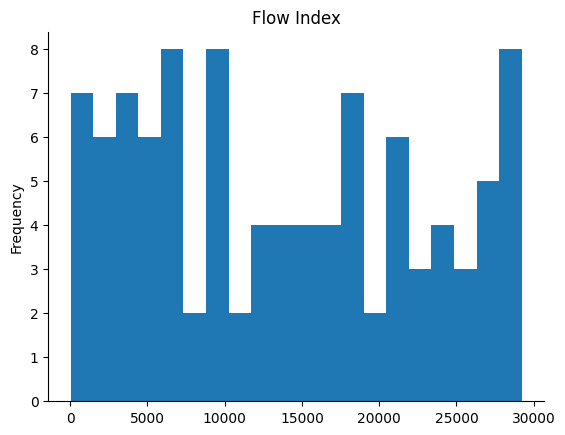

In [43]:
# @title Flow Index

from matplotlib import pyplot as plt
df_qkd['Flow Index'].plot(kind='hist', bins=20, title='Flow Index')
plt.gca().spines[['top', 'right',]].set_visible(False)

✅ Pre-trained model loaded successfully!
Loading fitted scaler...
✅ Scaler loaded successfully
Loading unseen test data...
Test data shape: (29364, 42)
Features: (29364, 41), Labels: (29364,)
Preprocessing data...
Reshaped data: (29364, 41, 1)
Making predictions...
918/918 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
✅ Predictions completed! Predicted 29364 samples

📊 Model Performance on UNSEEN Data:
              precision    recall  f1-score   support

           0     0.9788    0.9761    0.9774     14217
           1     0.9756    0.9546    0.9650      6694
           2     0.8725    0.7798    0.8235       386
           3     0.9955    0.9966    0.9961      3813
           4     0.8652    0.9231    0.8932       897
           5     0.9637    0.9423    0.9529      3327
           6     0.0171    0.8000    0.0335         5
           7     0.6333    0.7600    0.6909        25

    accuracy                         0.9656     29364
   macro avg     0.7877    0.8916    0.7916     29364
weighted av

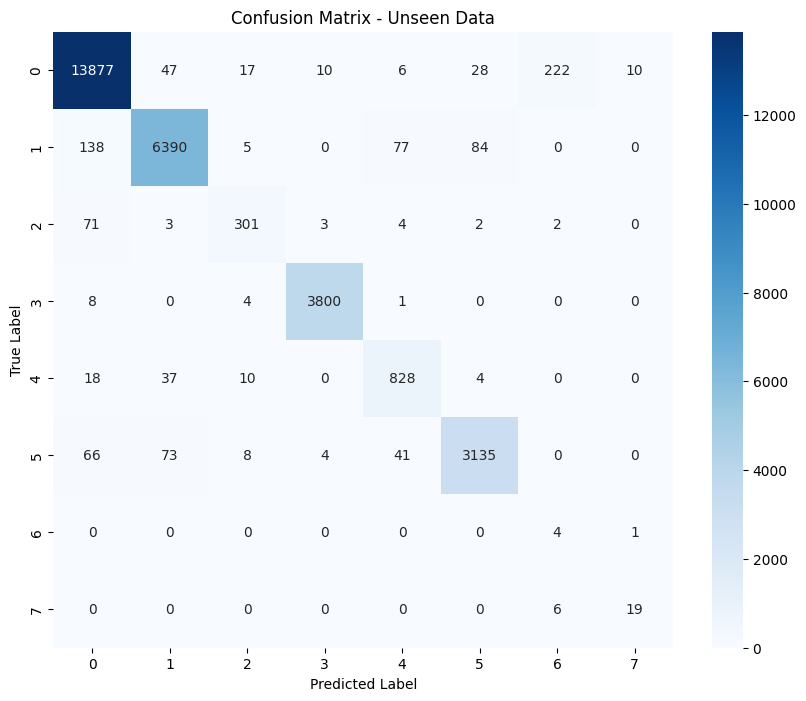


🎯 Per-Class Accuracy:
Class 0: 0.9761 (samples: 14217)
Class 1: 0.9546 (samples: 6694)
Class 2: 0.7798 (samples: 386)
Class 3: 0.9966 (samples: 3813)
Class 4: 0.9231 (samples: 897)
Class 5: 0.9423 (samples: 3327)
Class 6: 0.8000 (samples: 5)
Class 7: 0.7600 (samples: 25)


In [30]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load your pre-trained model
#print("Loading pre-trained model...")
#model = tf.keras.models.load_model('/content/trained_sdn_security_model.keras')  # Replace with your model file
#print("✅ Model loaded successfully")

import tensorflow as tf

# Re-define your focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        probs = tf.reduce_sum(y_true * y_pred, axis=1)
        focal = alpha * tf.pow((1. - probs), gamma) * cross_entropy
        return focal
    return focal_loss_fixed

# Load model with custom loss
model = tf.keras.models.load_model(
    "best_model.keras",
    custom_objects={"focal_loss_fixed": focal_loss()}
)

print("✅ Pre-trained model loaded successfully!")


# 2. Load the fitted scaler
print("Loading fitted scaler...")
scaler = joblib.load('/content/scaler_qkd.save')  # Replace with your scaler file
print("✅ Scaler loaded successfully")

# 3. Load unseen test data
print("Loading unseen test data...")
test_df = pd.read_csv('/content/test_data.csv')  # Replace with your test file
print(f"Test data shape: {test_df.shape}")

# 4. Separate features and labels (if available)
if 'Unified_Label' in test_df.columns:
    X_test_unseen = test_df.drop('Unified_Label', axis=1).values
    y_test_unseen = test_df['Unified_Label'].values
    print(f"Features: {X_test_unseen.shape}, Labels: {y_test_unseen.shape}")
else:
    X_test_unseen = test_df.values
    print(f"Features only: {X_test_unseen.shape}")

# 5. Apply the SAME preprocessing as training
print("Preprocessing data...")
X_test_scaled = scaler.transform(X_test_unseen)  # Use the fitted scaler

# 6. Reshape for CNN-LSTM input
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
print(f"Reshaped data: {X_test_reshaped.shape}")

# 7. Make predictions
print("Making predictions...")
y_pred_probs = model.predict(X_test_reshaped, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels (0-7)

print(f"✅ Predictions completed! Predicted {len(y_pred)} samples")

# 8. Evaluate performance (if you have true labels)
if 'Unified_Label' in test_df.columns:
    print("\n📊 Model Performance on UNSEEN Data:")
    print(classification_report(y_test_unseen, y_pred, digits=4))
    print(f"Overall Accuracy: {accuracy_score(y_test_unseen, y_pred):.4f}")

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_unseen, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Unseen Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Per-class accuracy
    print("\n🎯 Per-Class Accuracy:")
    for class_id in np.unique(y_test_unseen):
        class_mask = y_test_unseen == class_id
        if np.sum(class_mask) > 0:  # Avoid division by zero
            class_accuracy = accuracy_score(y_test_unseen[class_mask], y_pred[class_mask])
            print(f"Class {class_id}: {class_accuracy:.4f} (samples: {np.sum(class_mask)})")
else:
    print("\n🎯 Prediction results ready!")
    print(f"Predicted classes: {np.unique(y_pred, return_counts=True)}")
    print("First 10 predictions:", y_pred[:10])

In [32]:
y_pred_probs = model.predict(X_test_reshaped)
print("Prediction distribution (mean probabilities):")
print(np.mean(y_pred_probs, axis=0))

918/918 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
Prediction distribution (mean probabilities):
[0.4427999  0.2524538  0.02365293 0.12771986 0.02556191 0.12021224
 0.00664081 0.00094645]


In [23]:
# --- Cell 5: Save Everything ---
from google.colab import files
files.download('trained_sdn_security_model.keras')
files.download('qkd_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Save these excellent results for your thesis
results = {
    'overall_accuracy': 0.9865,
    'precision_macro': 0.8221,
    'recall_macro': 0.9412,
    'f1_macro': 0.8484
}

import json
with open('model_performance_results.json', 'w') as f:
    json.dump(results, f)

print("✅ Performance results saved for your research paper!")

✅ Performance results saved for your research paper!


In [ ]:
'''def offline_integration_test():
    try:
        print("1. Starting QKD simulation...")

        # Add timeout protection
        import signal
        def timeout_handler(signum, frame):
            raise TimeoutError("QKD simulation timed out")

        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(30)  # 30 second timeout

        # 1. Generate QKD Key
        key, qber = simulate_bb84_key(eavesdrop_prob=0.1)
        signal.alarm(0)  # Disable alarm

        print(f"   QKD completed. Key: {key is not None}, QBER: {qber}")
        if key is None:
            return

        print("2. Getting test sample...")
        idx = np.random.randint(0, len(X_test))
        flow_features, true_label = X_test[idx], y_test[idx]
        print(f"   Sample index: {idx}, True label: {true_label}")

        '''print("3. Making prediction...")
        prediction = model.predict(flow_features.reshape(1, 41, 1), verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        attack_detected = predicted_class != 0
        print(f"   Prediction: {predicted_class}, Attack detected: {attack_detected}")'''

        print("3. Making prediction...")
        prediction = model.predict(flow_features.reshape(1, 41, 1), verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        attack_detected = predicted_class != 0

        # ADD THIS LINE:
        print(f"   Prediction probabilities: {prediction[0].round(4)}")
        print(f"   Predicted class: {predicted_class}, Attack detected: {attack_detected}")

        '''# 3. Predict with your pre-trained model
        prediction = model.predict(flow_features.reshape(1, 41, 1), verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]  # Get actual class (0-7)

        # CORRECT: Check if predicted class is not normal (0)
        attack_detected = predicted_class != 0

        # Or better: show the actual prediction
        print(f"   Prediction probabilities: {prediction[0]}")
        print(f"   Predicted class: {predicted_class}")'''

        print("4. Encrypting message...")
        msg = "drop_flow" if attack_detected else "allow_flow"
        encrypted_msg = aes_encrypt(key, msg)
        decrypted_msg = aes_decrypt(key, encrypted_msg)
        print(f"   Message: {msg}, Decrypted: {decrypted_msg.decode()}")

    except TimeoutError:
        print("❌ QKD simulation timed out after 30 seconds")
    except Exception as e:
        print(f"❌ ERROR: {e}")
        import traceback
        traceback.print_exc()

# Run test
print("🚀 Starting integration test with timeout protection...")
offline_integration_test()'''